# Load Spike Shape Models

In [1]:
using Revise,CSV,FileIO,Tables
shapes = [Tables.columns(CSV.File("spikeshapes.csv",datarow=1,allowmissing=:auto,transpose=true))...];

# Choose Units

In [2]:
using StatsBase
nunit = 3
units = sample(shapes,nunit,replace=false);

# Generate Units Spikes

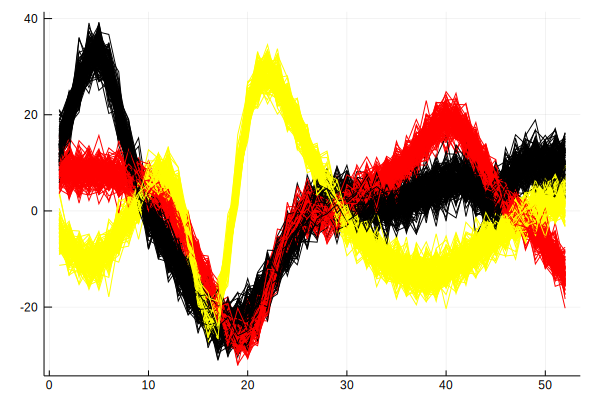

In [4]:
using SpikeSorting,Plots
nspike=500;spikelength=52
uid = rand(1:nunit,nspike)
spike = hcat((spikeshape(1:spikelength,units[uid[i]]...,snr=5) for i in 1:nspike)...)
plot(spike,color=unitscolor[uid'],legend=:none)

# Prepare Units Spikes

In [5]:
using Flux
inputn = 256;outputn=16
y = Flux.onehotbatch(uid,1:outputn)
t,x=resample(spike,inputn)
plot(t,x,color=unitscolor[uid'],legend=:none)

# Neural Network Model

In [6]:
featuren=48;unitmemoryn=32;
model = Chain(Dense(inputn,inputn,σ),Dense(inputn,featuren,elu),Dense(featuren,featuren,elu),LSTM(featuren,unitmemoryn),Dense(unitmemoryn,outputn,relu))

Chain(Dense(256, 256, NNlib.σ), Dense(256, 48, NNlib.elu), Dense(48, 48, NNlib.elu), Recur(LSTMCell(48, 32)), Dense(32, 16, NNlib.relu))

## Training Model

In [7]:
η = 0.001
loss(x, y) = Flux.crossentropy(softmax(model(x)), y)
optimiser = ADAM(params(model),η,decay=0.0)
callback = ()->@show loss(x,y)

#7 (generic function with 1 method)

In [16]:
Flux.@epochs 4 Flux.train!(loss, [(x,y)], optimiser,cb = Flux.throttle(callback, 1))

loss(x, y) = 0.48222694697362445 (tracked)


┌ Info: Epoch 1
└ @ Main C:\Users\Alex\.julia\packages\Flux\jsf3Y\src\optimise\train.jl:93


loss(x, y) = 0.44629148760434595 (tracked)


┌ Info: Epoch 2
└ @ Main C:\Users\Alex\.julia\packages\Flux\jsf3Y\src\optimise\train.jl:93
┌ Info: Epoch 3
└ @ Main C:\Users\Alex\.julia\packages\Flux\jsf3Y\src\optimise\train.jl:93


loss(x, y) = 0.41304321988932097 (tracked)


┌ Info: Epoch 4
└ @ Main C:\Users\Alex\.julia\packages\Flux\jsf3Y\src\optimise\train.jl:93


loss(x, y) = 0.3819660622670707 (tracked)


## Model Prediction

In [17]:
ŷ = model(x)
û = Flux.onecold(ŷ,1:outputn)
plot(t,x,color=unitscolor[û'],legend=:none)

## Save Model

In [ ]:
Flux.truncate!(model)
Flux.reset!(model)
save("dnn.jld2","model",model)